In [6]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [5]:
retaildata= pd.read_excel('/Users/mubinaarastu/Machine Learning Models/Dataset/Online Retail.xlsx')

In [3]:
retaildata.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

## Exploratory Data Analysis (EDA)

In [48]:
obs= retaildata.shape[0]
obs

541909

In [38]:
print('Counts..')
retaildata.apply(lambda x: x.count())

Counts..


InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [37]:
print('Data Types..')
retaildata.dtypes

Data Types..


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [35]:
print('Uniques...')
retaildata.apply(lambda x: [x.unique()])


Uniques...


InvoiceNo  \
0  [536365, 536366, 536367, 536368, 536369, 53637...   

                                           StockCode  \
0  [85123A, 71053, 84406B, 84029G, 84029E, 22752,...   

                                         Description  \
0  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...   

                                            Quantity  \
0  [6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...   

                                         InvoiceDate  \
0  [2010-12-01T08:26:00.000000000, 2010-12-01T08:...   

                                           UnitPrice  \
0  [2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...   

                                          CustomerID  \
0  [17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...   

                                             Country  
0  [United Kingdom, France, Australia, Netherland...

In [34]:
print('Nulls..')
retaildata.isnull().sum()

Nulls..


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [32]:
print('Distincts..')
retaildata.apply(lambda x: x.unique().shape[0])

Distincts..


InvoiceNo      25900
StockCode       4070
Description     4224
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4373
Country           38
dtype: int64

In [52]:
print('Missing Ratio')
round(((retaildata.isnull().sum()/ obs) * 100), 2)

Missing Ratio


InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [53]:
skewness = retaildata.skew()
skewness

Quantity       -0.264076
UnitPrice     186.506972
CustomerID      0.029835
dtype: float64

In [54]:
kurtosis = retaildata.kurt() 
kurtosis

Quantity      119769.160031
UnitPrice      59005.719097
CustomerID        -1.179982
dtype: float64

In [56]:
cs_df=retaildata

We can observe from the preceding output that Quantity and UnitPrice are having negative values, which may mean that we may have some return transactions in our data also. As our goal is customer segmentation and market basket analysis, it is important that these records are removed, but first we will take a look at whether there are records where both are negative or if one of them is negative and the other is zero

In [57]:
print('Check if we had negative quantity and prices at same register:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].shape[0])
print('\nWhat is the customer ID of the registers above:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0), 
                ['CustomerID']].CustomerID.unique())
print('\n% Negative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))
print('\nAll register with negative quantity has Invoice start with:', 
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nSee an example of negative quantity and others related records:')
display(cs_df[(cs_df.CustomerID==12472) & (cs_df.StockCode==22244)])

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336

What is the customer ID of the registers above: [nan]

% Negative Quantity: 1.96%

All register with negative quantity has Invoice start with: ['C']

See an example of negative quantity and others related records:


InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice  CustomerID  Country  
1973   2010-12-01 14:33:00       1.95     12472.0  Germany  
9438   2010-12-05 14:19:00       1.95     12472.0  Germany  
121980 2011-03-17 12:40:00       1.95     12472.0  Germany

In [58]:
print('Check register with UnitPrice negative:')
display(cs_df[(cs_df.UnitPrice<0)])
print("Sales records with Customer ID and zero in Unit Price:",cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())].shape[0])
cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())]

Check register with UnitPrice negative:


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Sales records with Customer ID and zero in Unit Price: 40


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
157042 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
187613 2011-05-12 15:21:00       

As you can see, there are no records where quantity and price are negative, but there are 1.336 records where one of them is and the other is 0. However, note that for all these records we do not have the customer ID. So we conclude that we can erase all records in that quantity or the price and negative. In addition, by the foregoing summary we see that there are 135,080 records without customer identification that we may also disregard.

In [59]:
# Remove register without CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]

#details = rstr(cs_df)
#display(details.sort_values(by='distincts', ascending=False))

In [61]:
print('Missing Ratio')
round(((cs_df.isnull().sum()/ obs) * 100), 2)

Missing Ratio


InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

Cleaning is completed. No missing vals.

In [64]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
cat_des_df

StockCode                   Description  InvoiceNo  Quantity  \
0        10002   INFLATABLE POLITICAL GLOBE          49        49   
1        10080      GROOVY CACTUS INFLATABLE         21        21   
2        10120                  DOGGY RUBBER         30        30   
3        10125       MINI FUNKY DESIGN TAPES         64        64   
4        10133  COLOURING PENCILS BROWN TUBE        124       124   
...        ...                           ...        ...       ...   
3892        C2                      CARRIAGE        133       133   
3893       DOT                DOTCOM POSTAGE         16        16   
3894         M                        Manual        284       284   
3895      PADS    PADS TO MATCH ALL CUSHIONS          3         3   
3896      POST                       POSTAGE       1099      1099   

      InvoiceDate  UnitPrice  CustomerID  Country  
0              49         49          49       49  
1              21         21          21       21  
2              30         30          30       30  
3              64         64          64       64  
4             124        124         124      124  
...           ...        ...         ...      ...  
3892          133        133         133      133  
3893           16         16          16       16  
3894          284        284         284      284  
3895            3          3           3        3  
3896         1099       1099        1099     1099  

[3897 rows x 8 columns]

In [68]:
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head(10))


index  StockCode
0   23196          4
1   23236          4
2   23203          3
3  17107D          3
4   23535          3
5   23209          3
6   23131          3
7   22776          3
8   23413          3
9   23126          3

In [71]:
##Lets check by one index example----Duplicate Descriptions by stock code
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][3]]['Description'].unique()

array(["FLOWER FAIRY,5 SUMMER B'DRAW LINERS",
       'FLOWER FAIRY 5 DRAWER LINERS',
       'FLOWER FAIRY 5 SUMMER DRAW LINERS'], dtype=object)

This gives the multiple descriptions for stock code and this leads to data quality issues in any dataset. A simple spelling mistake can end up in reducing data quality and an erroneous analysis.

In [72]:
unique_desc = cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [76]:
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][3]]['Description'].unique()

array(["FLOWER FAIRY,5 SUMMER B'DRAW LINERS"], dtype=object)

#### Duplicate Descriptions are removed

In [74]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')

In [78]:
cs_df

InvoiceNo StockCode                          Description  Quantity  \
0          536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          536365     71053                  WHITE METAL LANTERN         6   
2          536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3          536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...           ...       ...                                  ...       ...   
397879     581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
397880     581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
397881     581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
397882     581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
397883     581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  amount  
0      2010-12-01 08:26:00       2.55       17850  United Kingdom   15.30  
1      2010-12-01 08:26:00       3.39       17850  United Kingdom   20.34  
2      2010-12-01 08:26:00       2.75       17850  United Kingdom   22.00  
3      2010-12-01 08:26:00       3.39       17850  United Kingdom   20.34  
4      2010-12-01 08:26:00       3.39       17850  United Kingdom   20.34  
...                    ...        ...         ...             ...     ...  
397879 2011-12-09 12:50:00       0.85       12680          France   10.20  
397880 2011-12-09 12:50:00       2.10       12680          France   12.60  
397881 2011-12-09 12:50:00       4.15       12680          France   16.60  
397882 2011-12-09 12:50:00       4.15       12680          France   16.60  
397883 2011-12-09 12:50:00       4.95       12680          France   14.85  

[397884 rows x 9 columns]

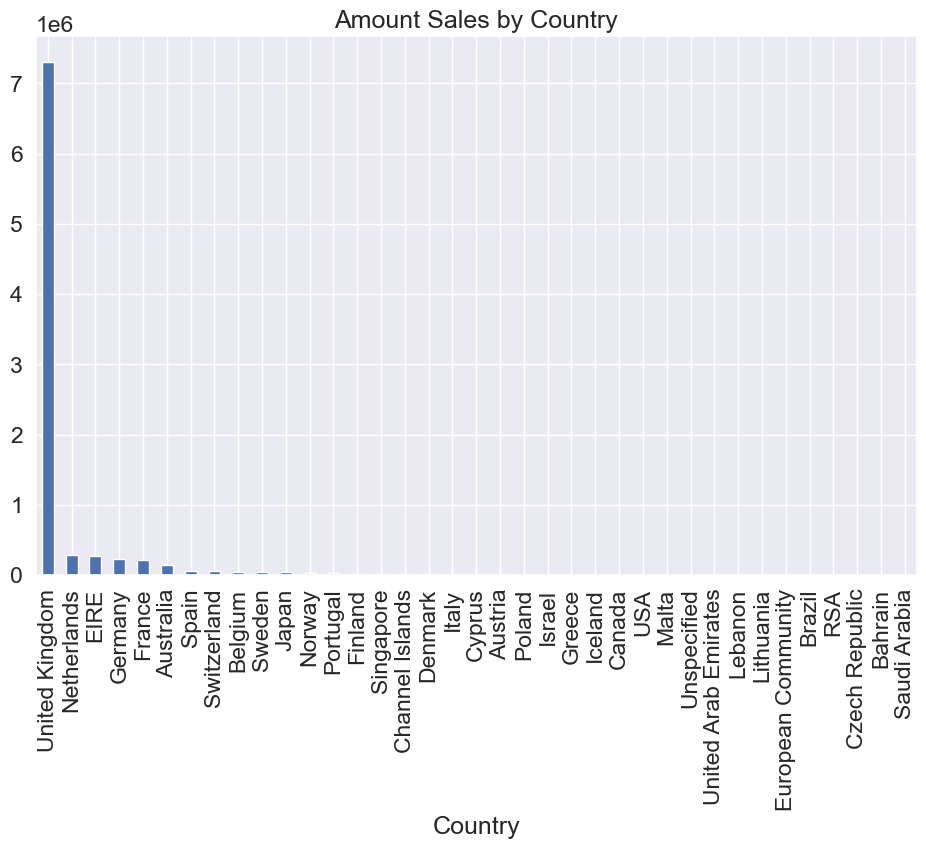

In [96]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')


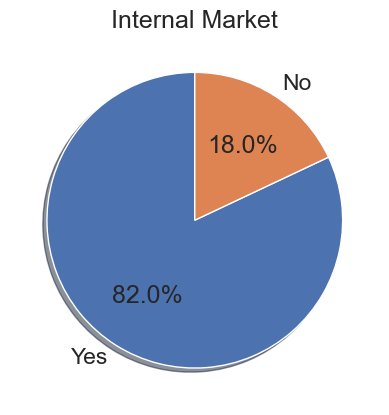

In [81]:
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

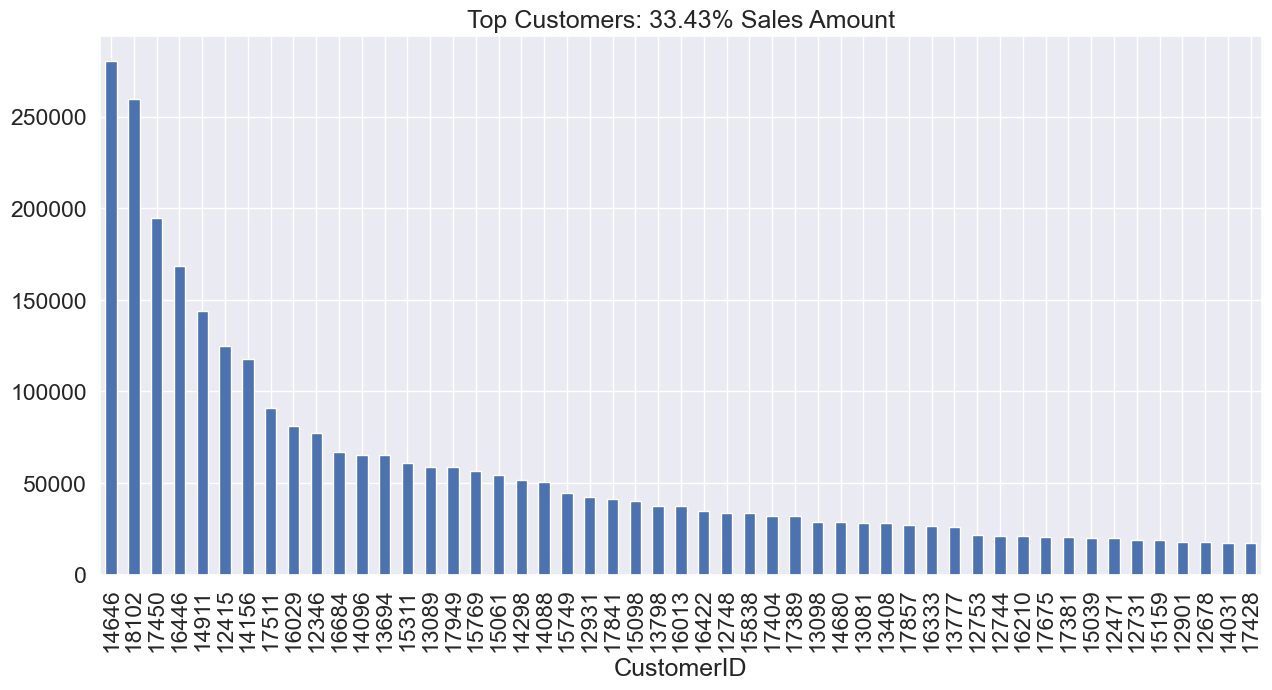

In [97]:
fig = plt.figure(figsize=(15, 7))
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))


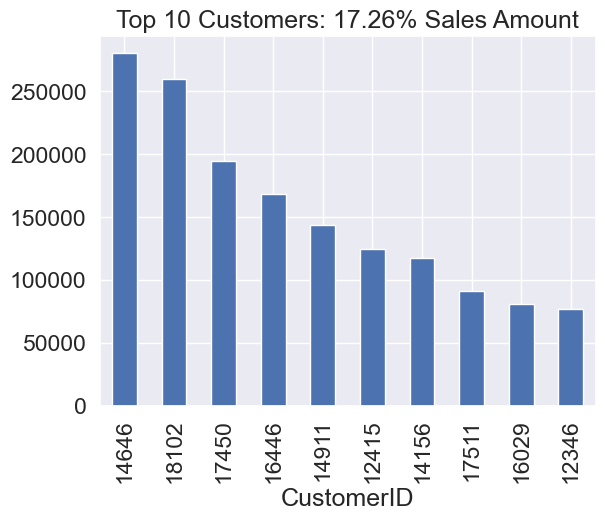

In [87]:
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amount'.format(PercentSales))

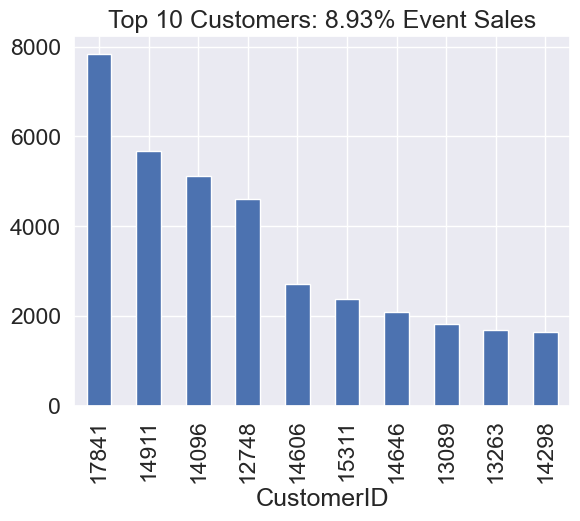

In [89]:
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

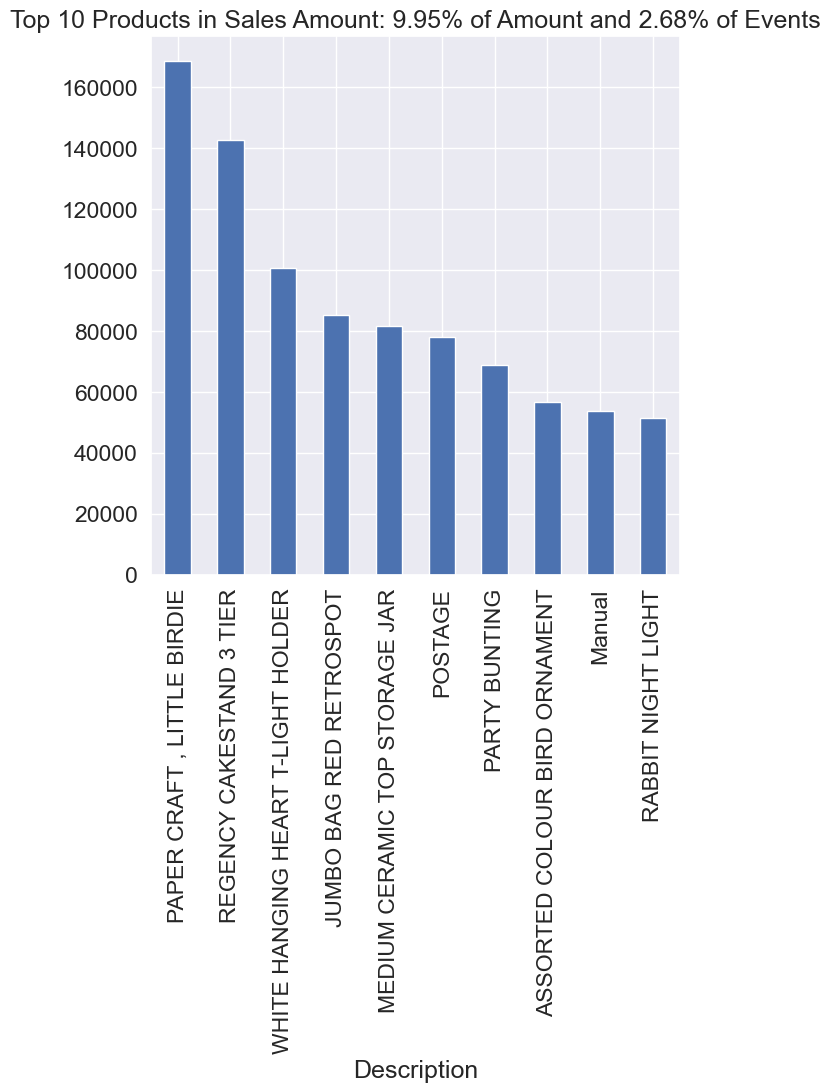

In [107]:
AmoutSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(15, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


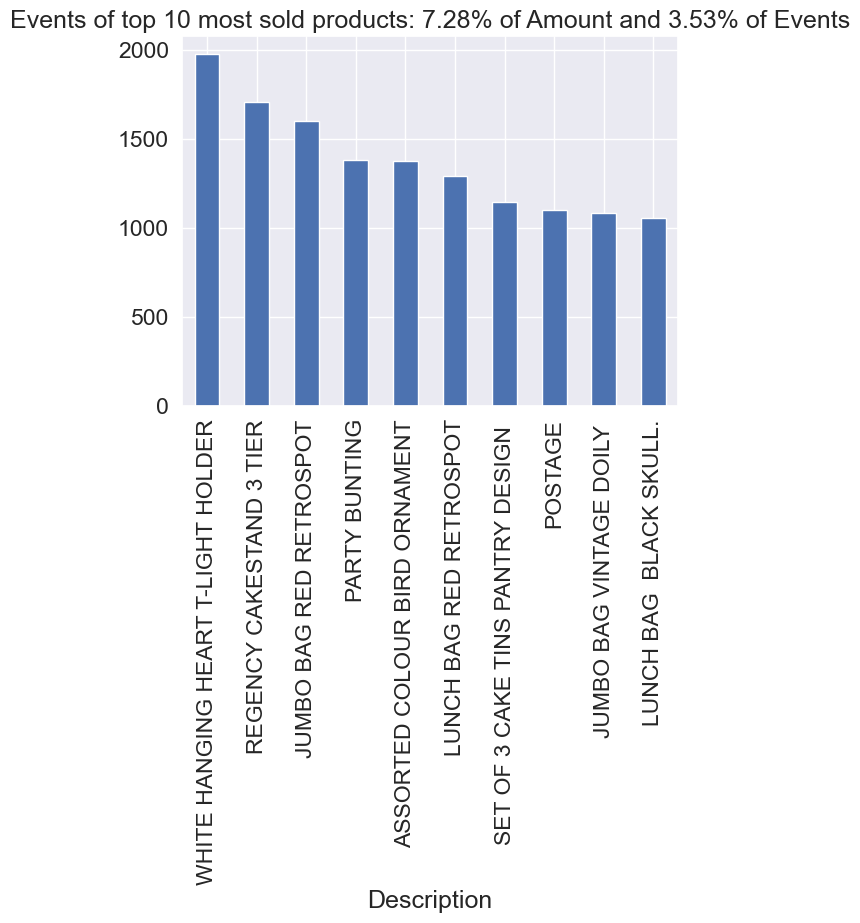

In [99]:
f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


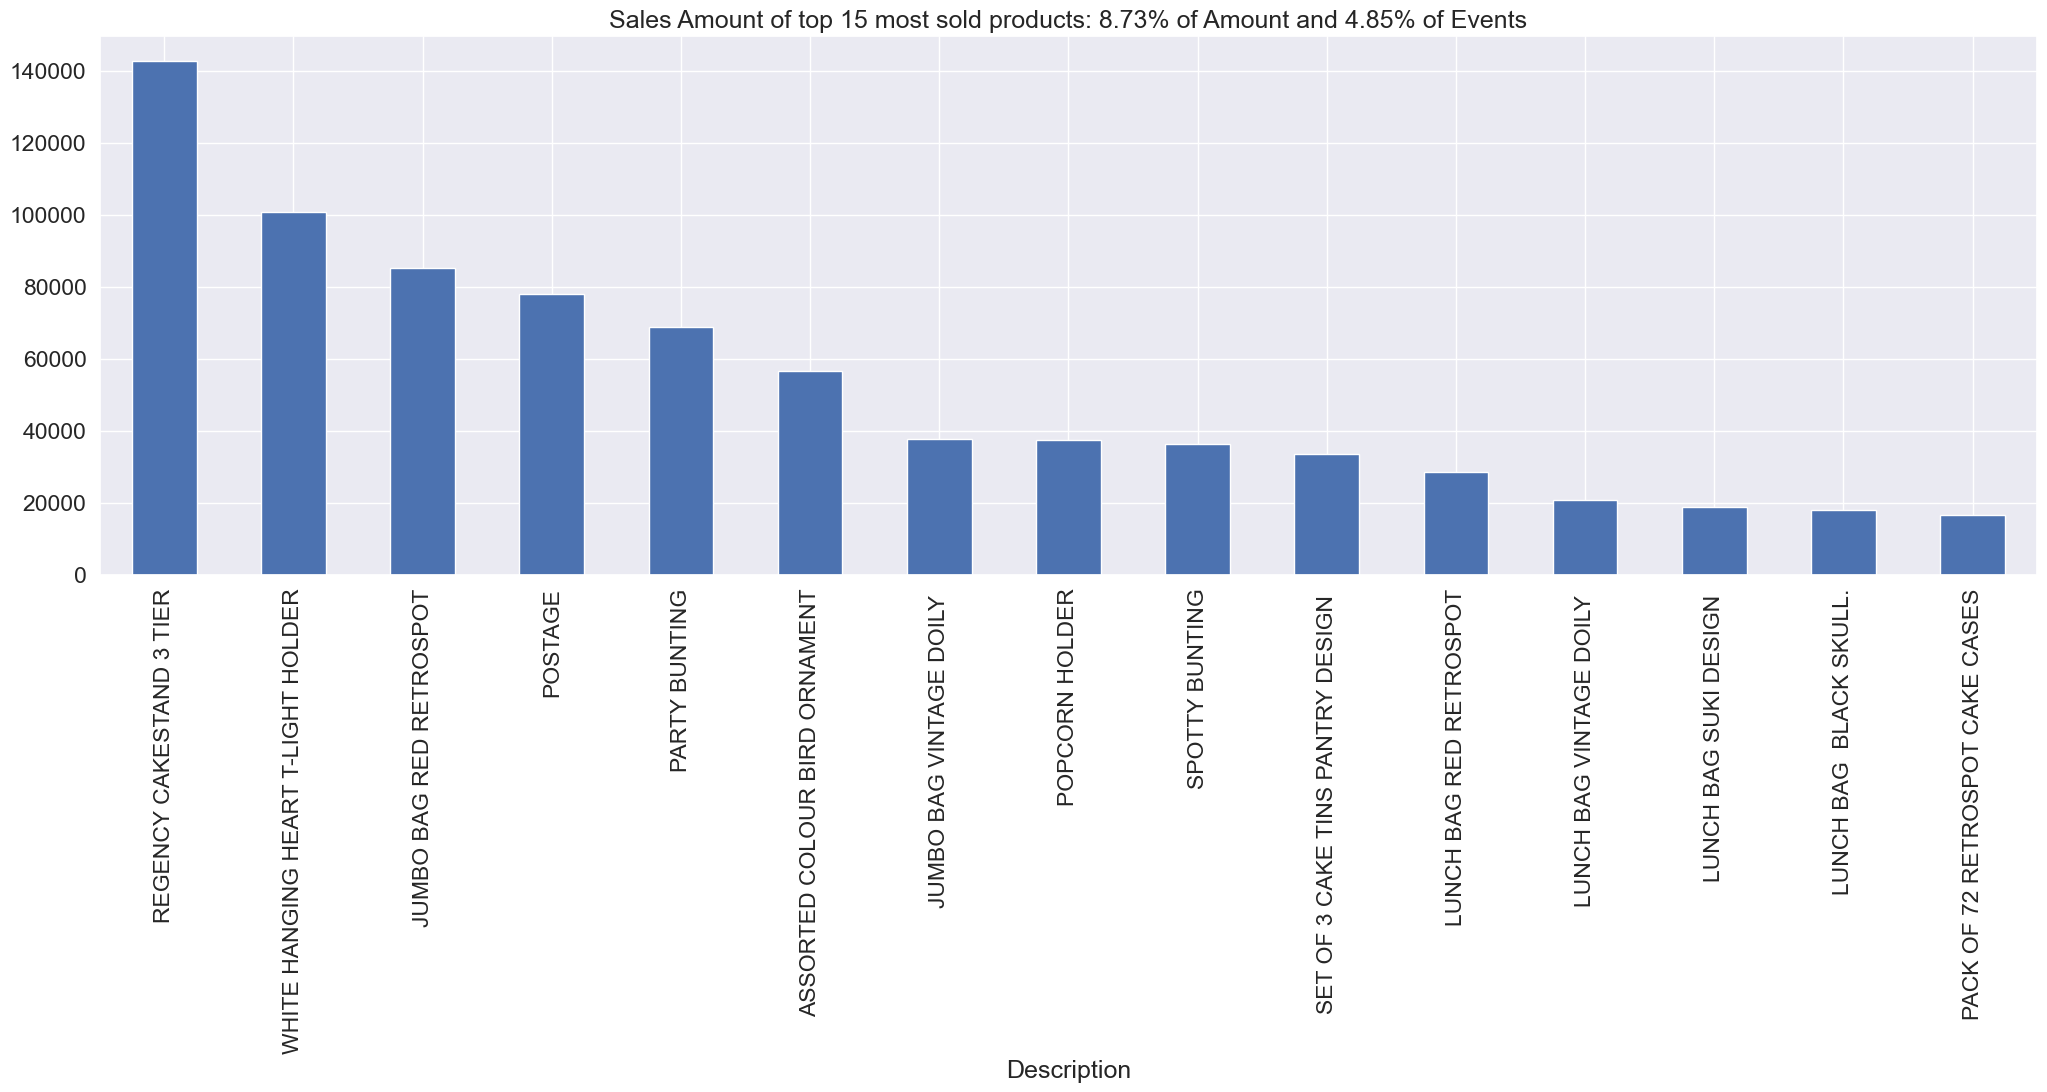

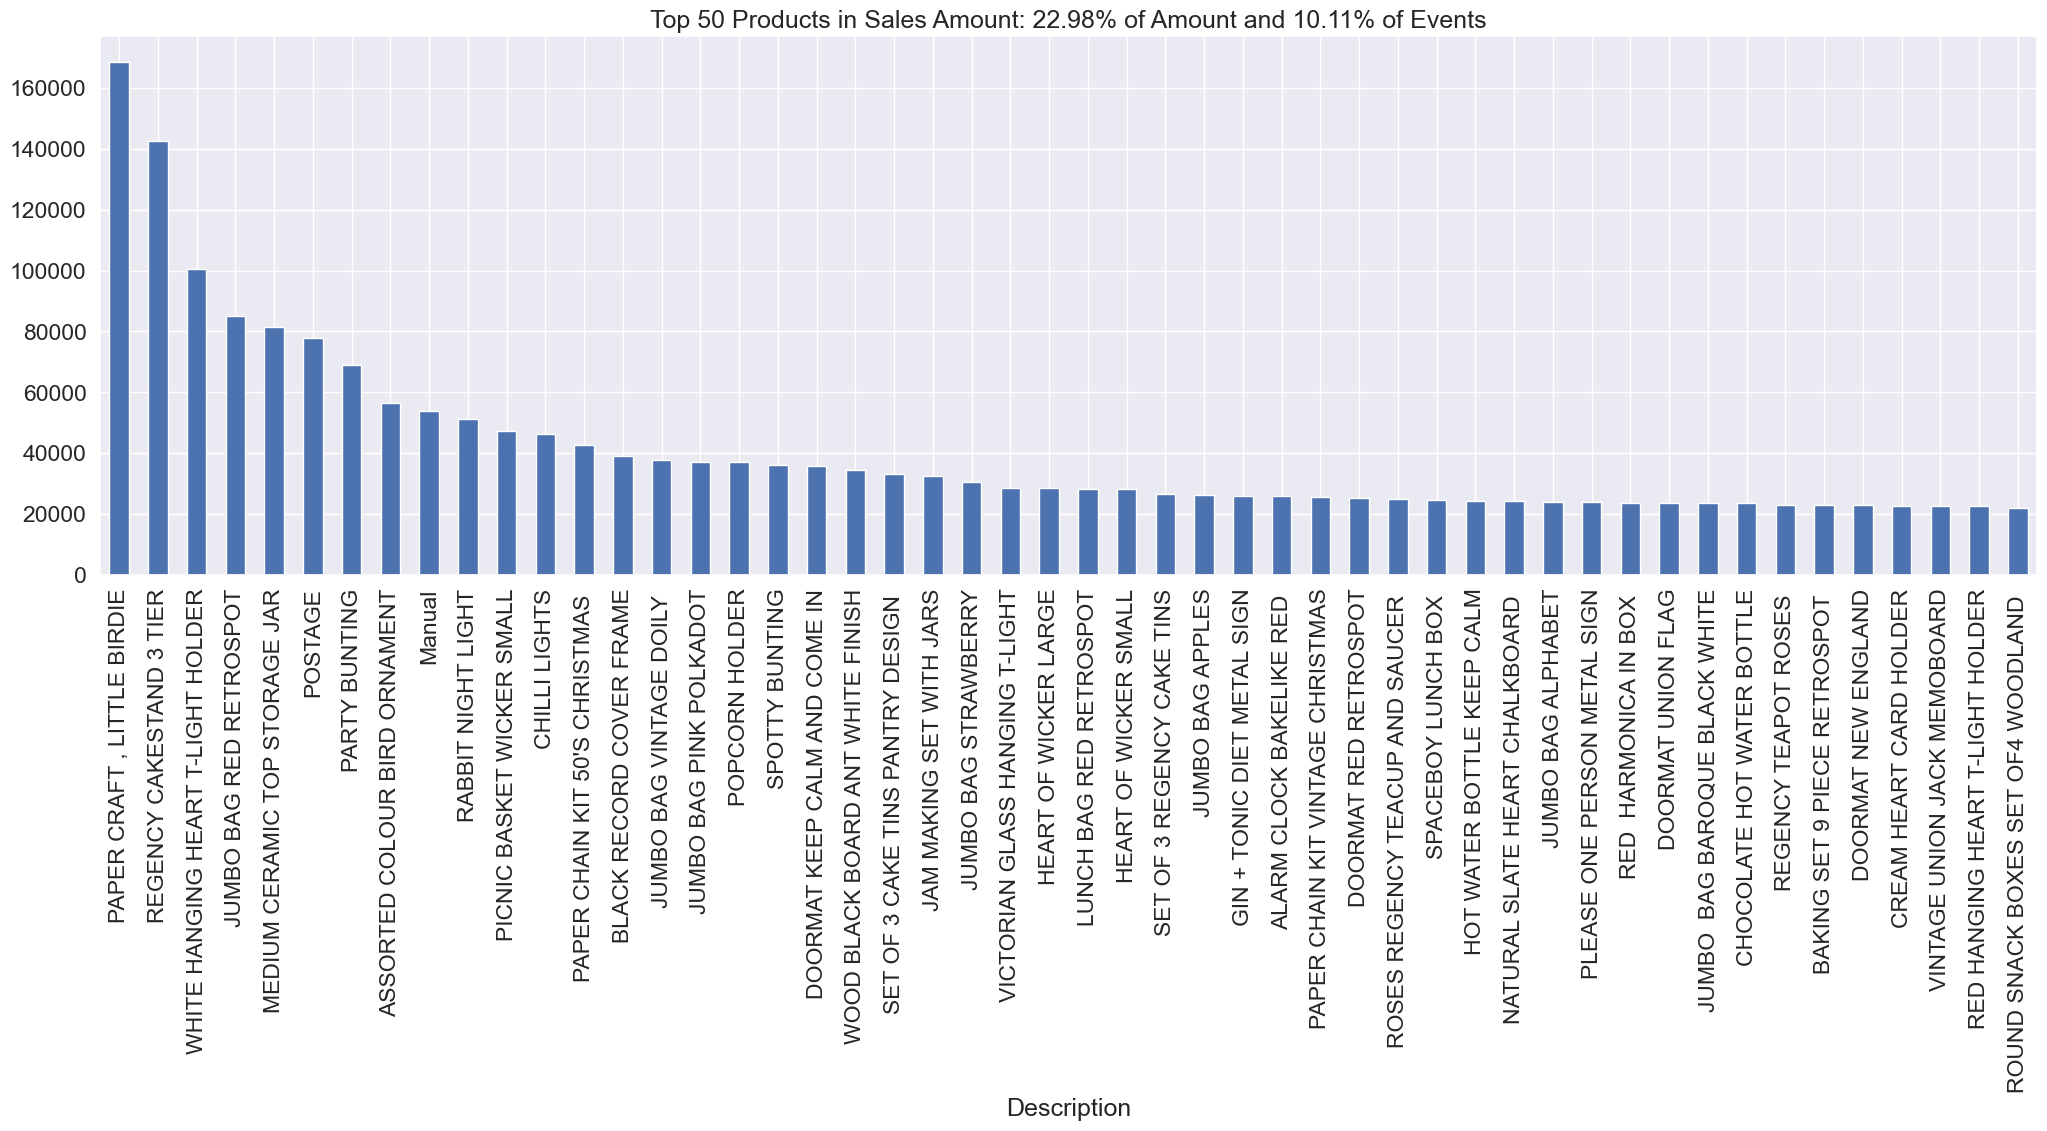

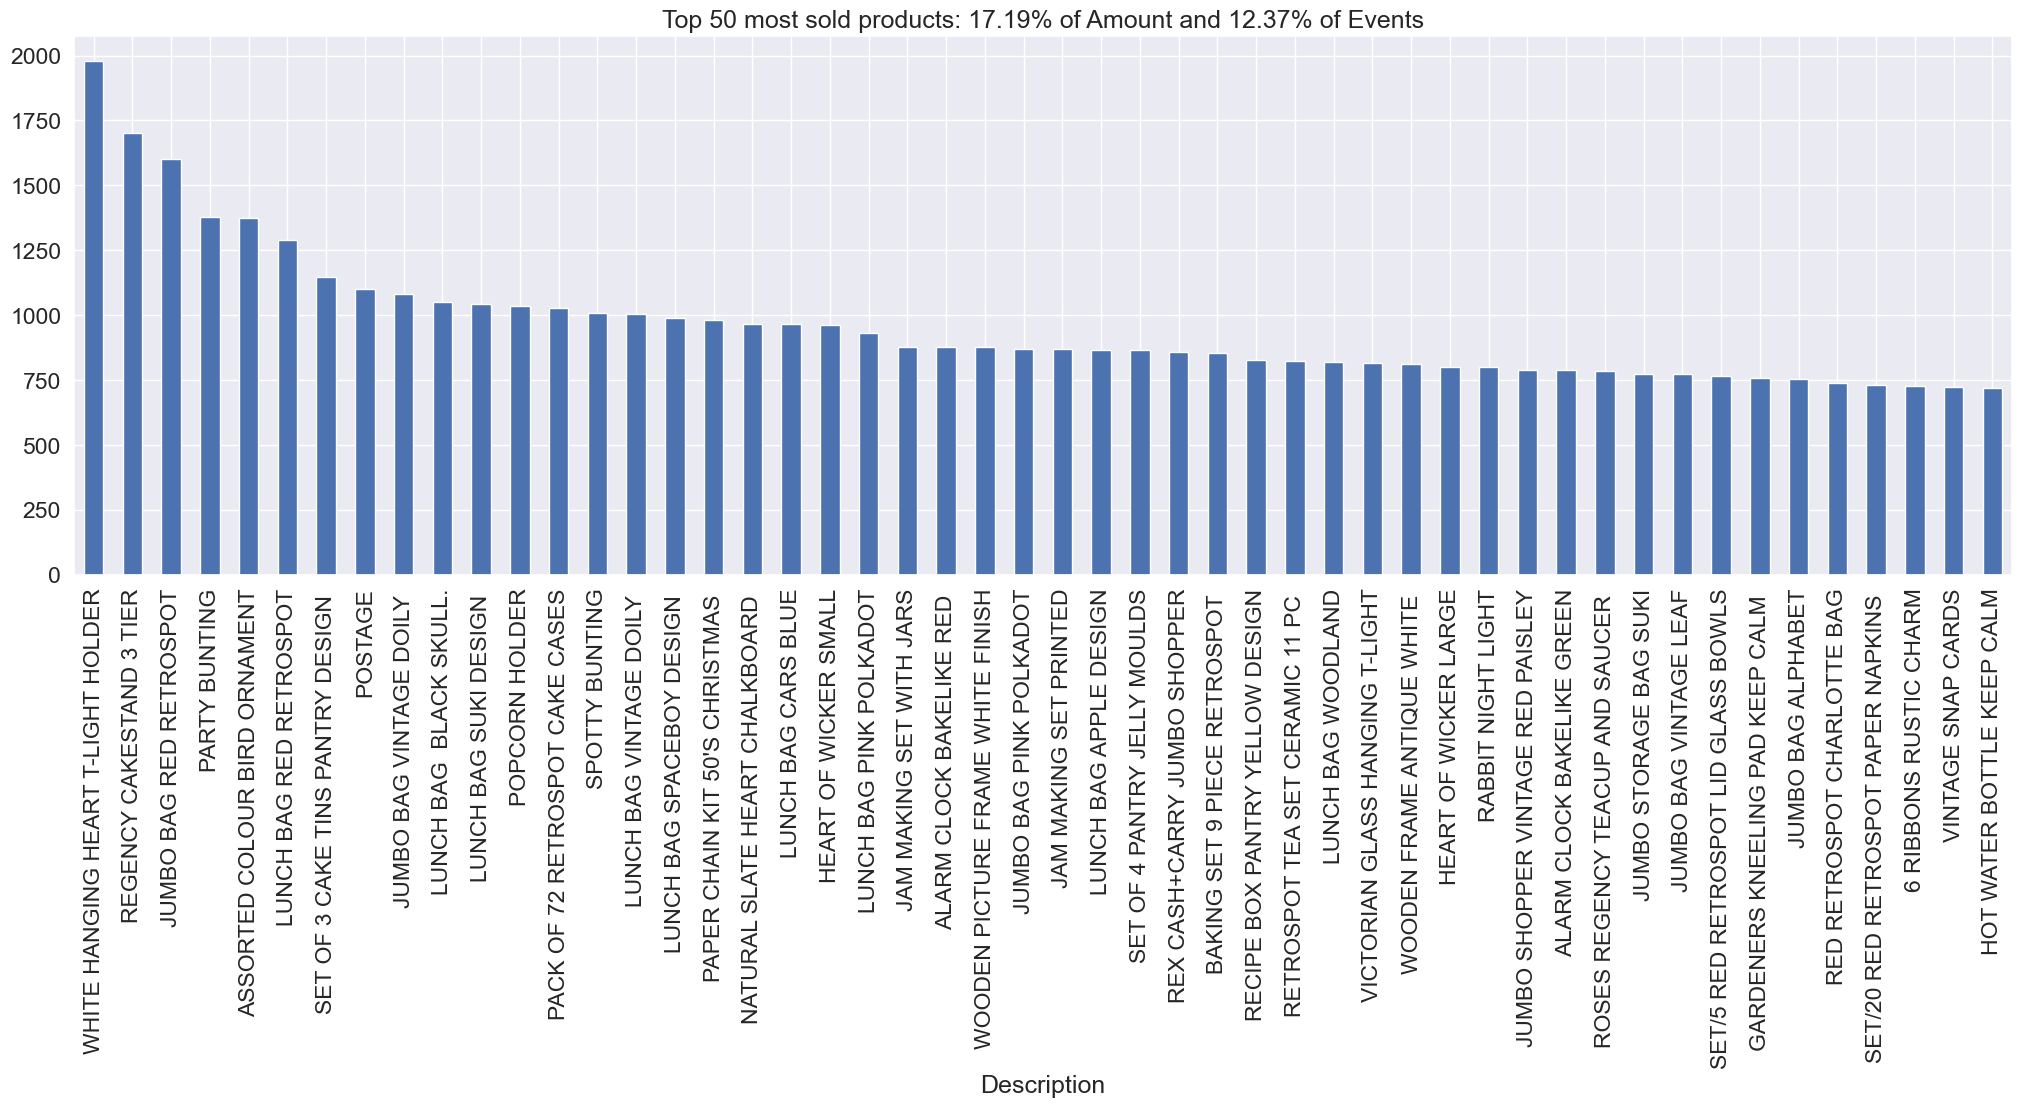

In [102]:
fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


## Customer Segmentation:

# 1. RFM Model for Customer Value:

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a **RFM**,***Recency, Frequency and Monetary Value**, based model of customer value for finding our customer segments.
 The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

### 1.1 Recency
To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [103]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0     18.00     51.0   

                 75%      max  
CustomerID  16778.75  18287.0  
recency       142.00    374.0

Let's plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

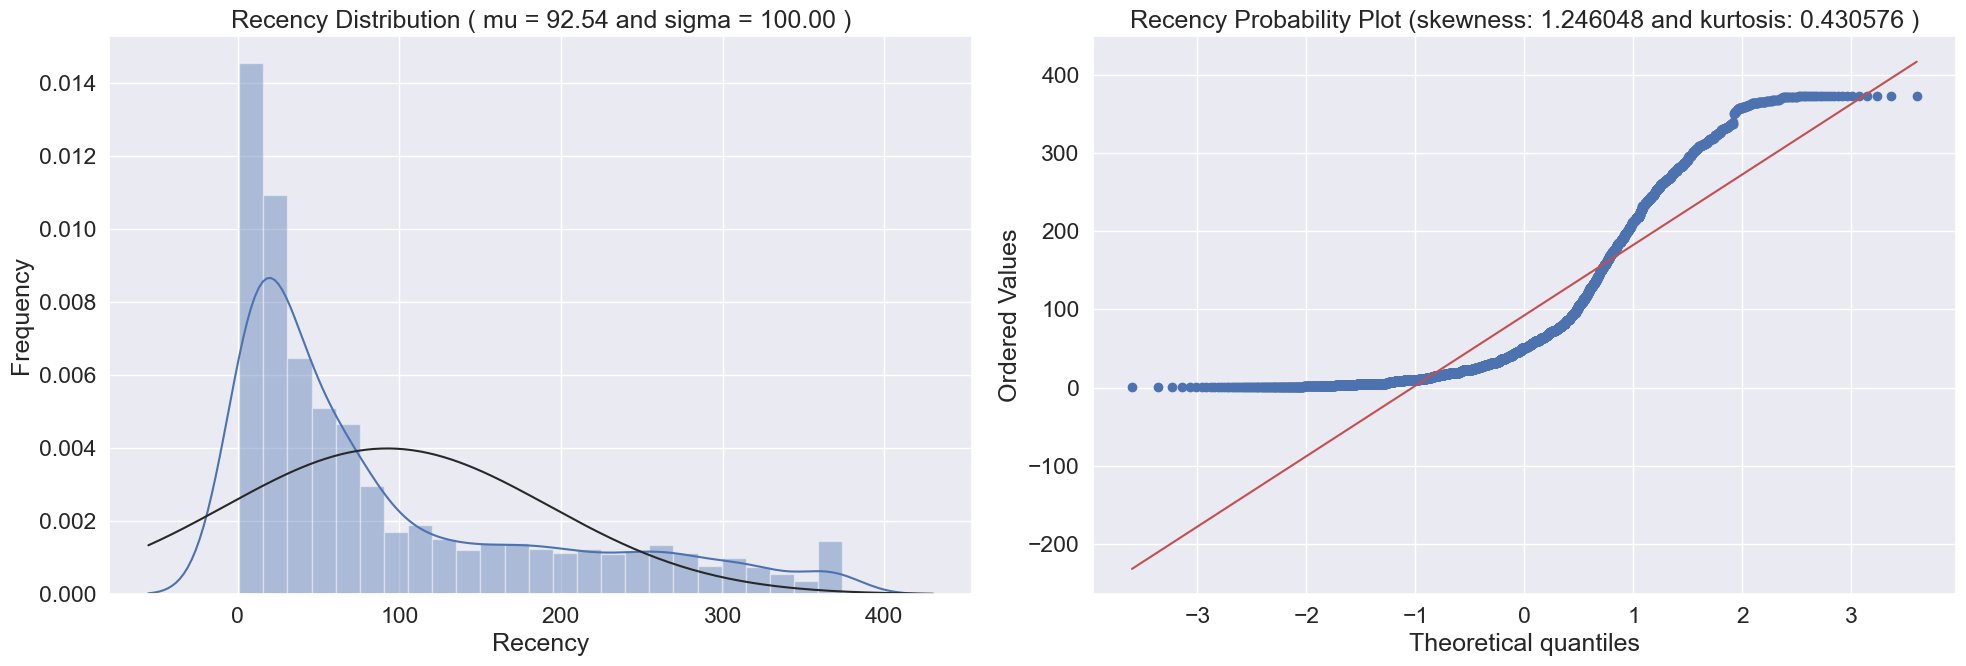

In [105]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

From the **Recency Distribution** above we can see that sales recency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the **Probability Plot**,, we could see that sales recency also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.
With **skewness positive of 1.25**, we confirm the lack of symmetry and indicate that sales recency are **skewed right**, as we can see too at the Sales Distribution plot, skewed right means that the right tail is long relative to the left tail. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.
**Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 0.43 of positive kurtosis sales recency are heavy-tailed and has some **outliers**.

### 1.2 Frequency

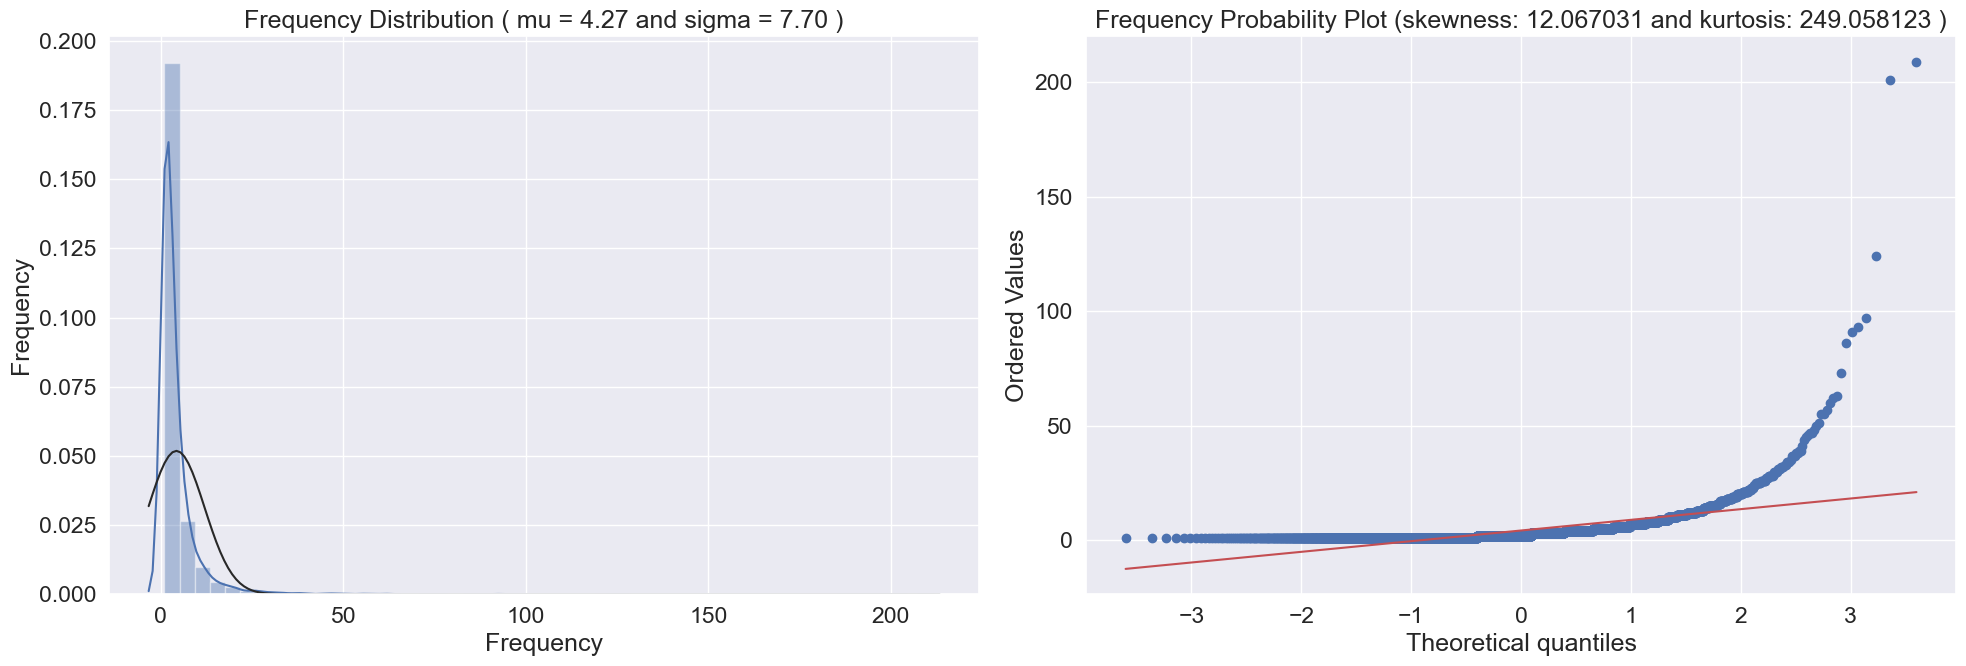

In [108]:
customer_freq = (cs_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

From the first graph above we can see that sales frequency distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.
From the Probability Plot, we could see that sales frequency also does **not align with the diagonal and confirm that is a skewed right.
With skewness positive of 12.1, we confirm the high lack of symmetry and with 249 Kurtosis indicates that is a heavy-tailed distribution and has outliers.

## Monetary Value

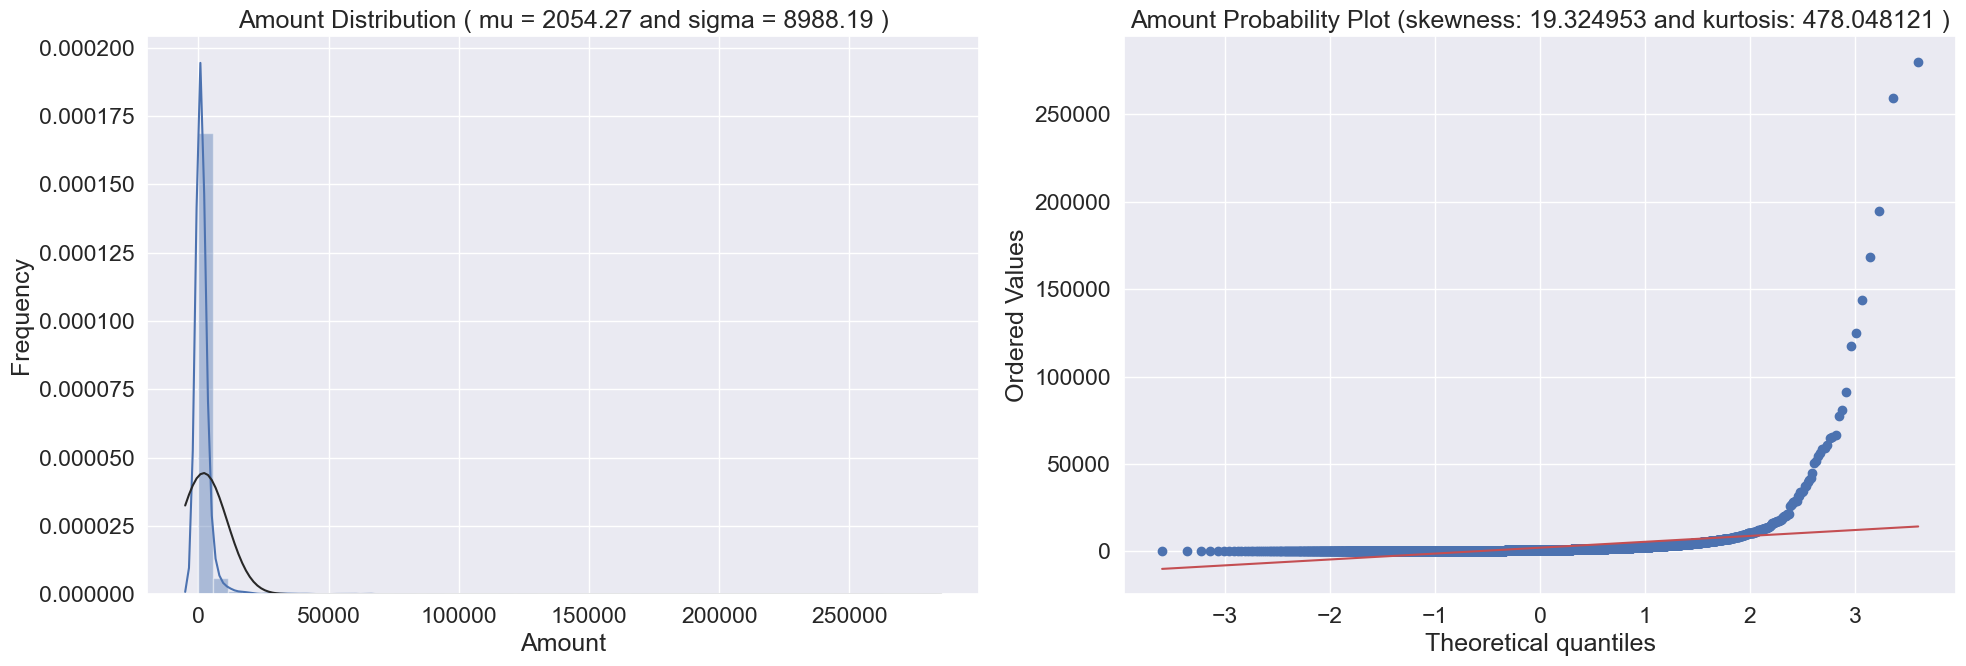

In [109]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

From the first graph above we can see that sales amount distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.
From the Probability Plot, we could see that sales amount also does not align with the diagonal, special on the right.
With skewness positive of 19.3, we confirm the high lack of symmetry and with 478 Kurtosis indicates that is a too heavy-tailed distribution and has outliers, surely more than 10 very extreme.
Let's see a statistical summary of this dataset:

In [110]:
customer_history_df.describe()

CustomerID      recency    frequency         amount
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

Once we have created our customer value dataset, we will perform some preprocessing on the data. For our clustering, we will be using the K-means clustering algorithm. One of the requirements for proper functioning of the algorithm is the mean centering of the variable values. Mean centering of a variable value means that we will replace the actual value of the variable with a standardized value, so that the variable has a mean of 0 and variance of 1. This ensures that all the variables are in the same range and the difference in ranges of values doesn't cause the algorithm to not perform well. This is akin to feature scaling.
Another problem that you can investigate about is the huge range of values each variable can take. This problem is particularly noticeable for the monetary amount variable. To take care of this problem, we will transform all the variables on the log scale. This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and transformed values.
An important point about the data preprocessing step is that sometimes we need it to be reversible. In our case, we will have the clustering results in terms of the log transformed and scaled variable. But to make inferences in terms of the original data, we will need to reverse transform all the variable so that we get back the actual RFM figures. This can be done by using the preprocessing capabilities of Python.

In [115]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
customer_history_df

CustomerID  recency  frequency    amount  recency_log  frequency_log  \
0          12346    326.0          1  77183.60     5.786897       0.000000   
1          12347      2.0          7   4310.00     0.693147       1.945910   
2          12348     75.0          4   1797.24     4.317488       1.386294   
3          12349     19.0          1   1757.55     2.944439       0.000000   
4          12350    310.0          1    334.40     5.736572       0.000000   
...          ...      ...        ...       ...          ...            ...   
4333       18280    278.0          1    180.60     5.627621       0.000000   
4334       18281    181.0          1     80.82     5.198497       0.000000   
4335       18282      8.0          2    178.05     2.079442       0.693147   
4336       18283      4.0         16   2094.88     1.386294       2.772589   
4337       18287     43.0          3   1837.28     3.761200       1.098612   

      amount_log  
0      11.253942  
1       8.368693  
2       7.494007  
3       7.471676  
4       5.812338  
...          ...  
4333    5.196285  
4334    4.392224  
4335    5.182064  
4336    7.647252  
4337    7.516041  

[4338 rows x 7 columns]

In [116]:
## create a feature store and tranform using scaler
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
amount_log     4338.0 -8.022628e-16  1.000115 -4.179280 -0.684183 -0.060942   
recency_log    4338.0 -1.027980e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -2.355833e-16  1.000115 -1.048610 -1.048610 -0.279044   

                    75%       max  
amount_log     0.654244  4.721395  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714

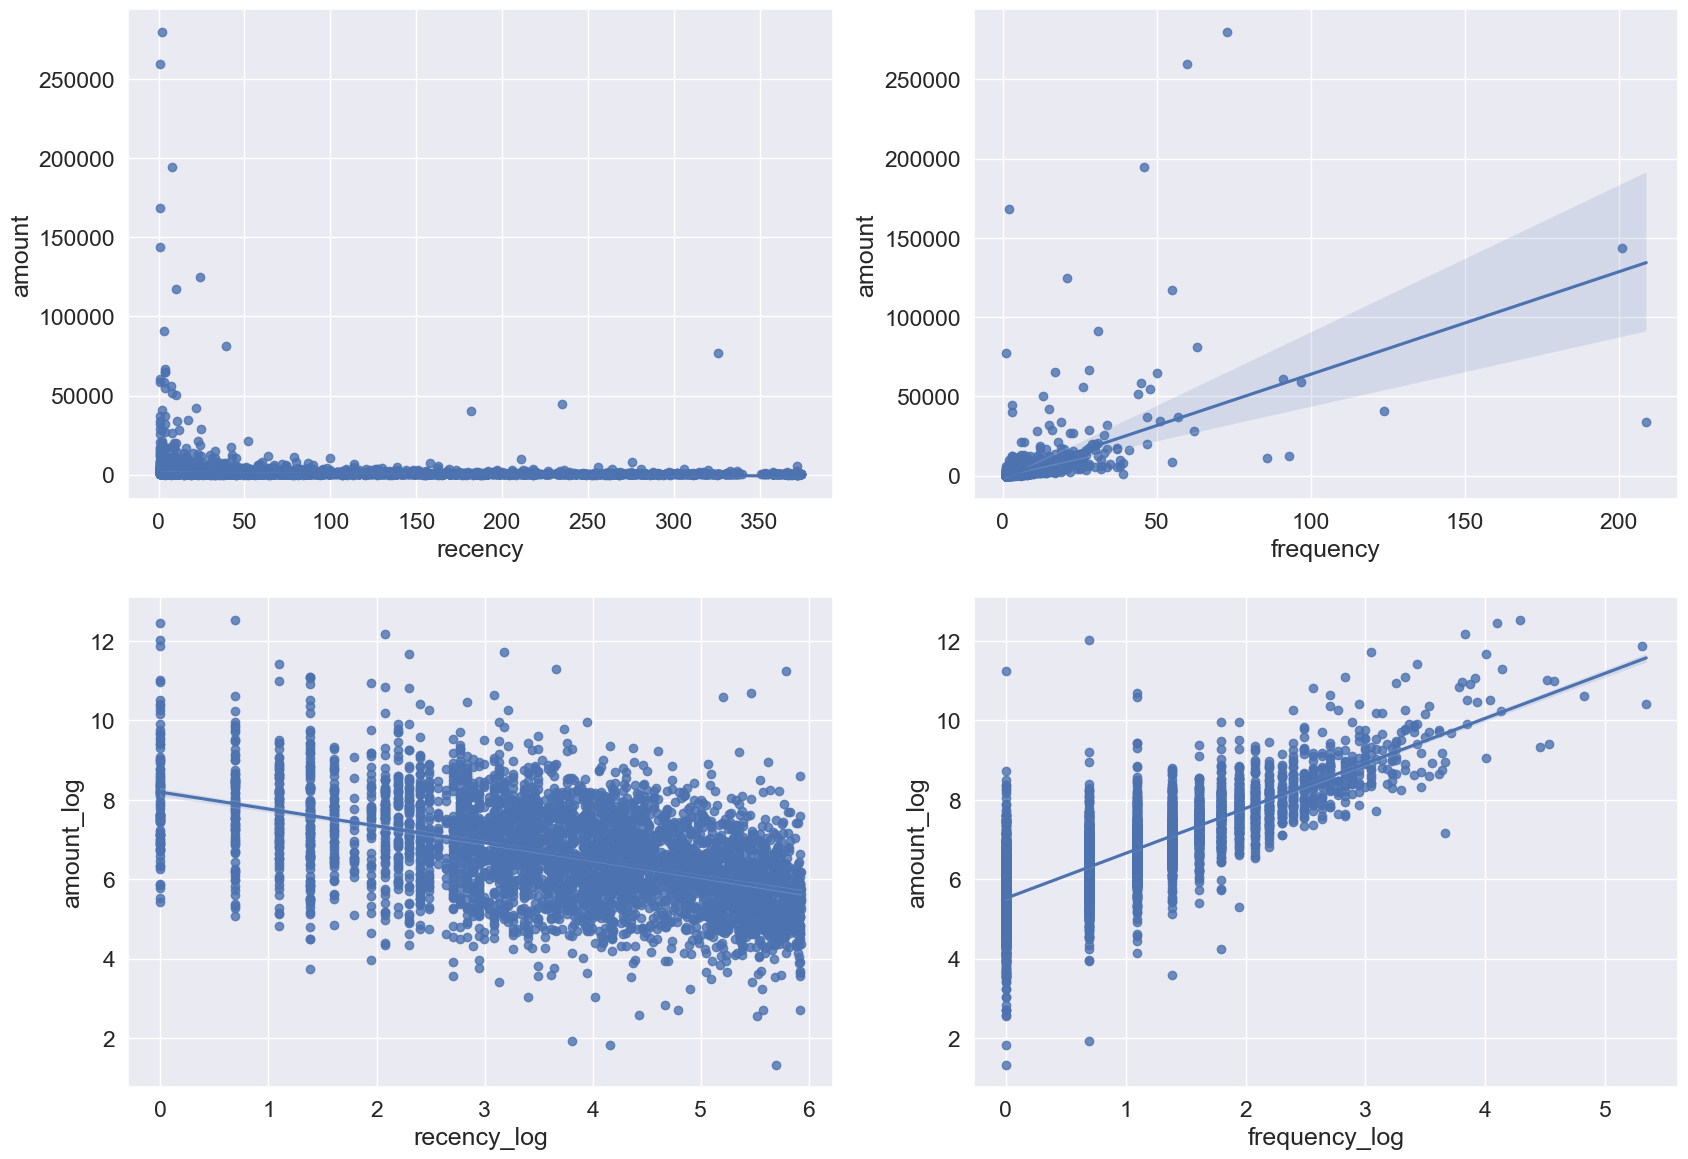

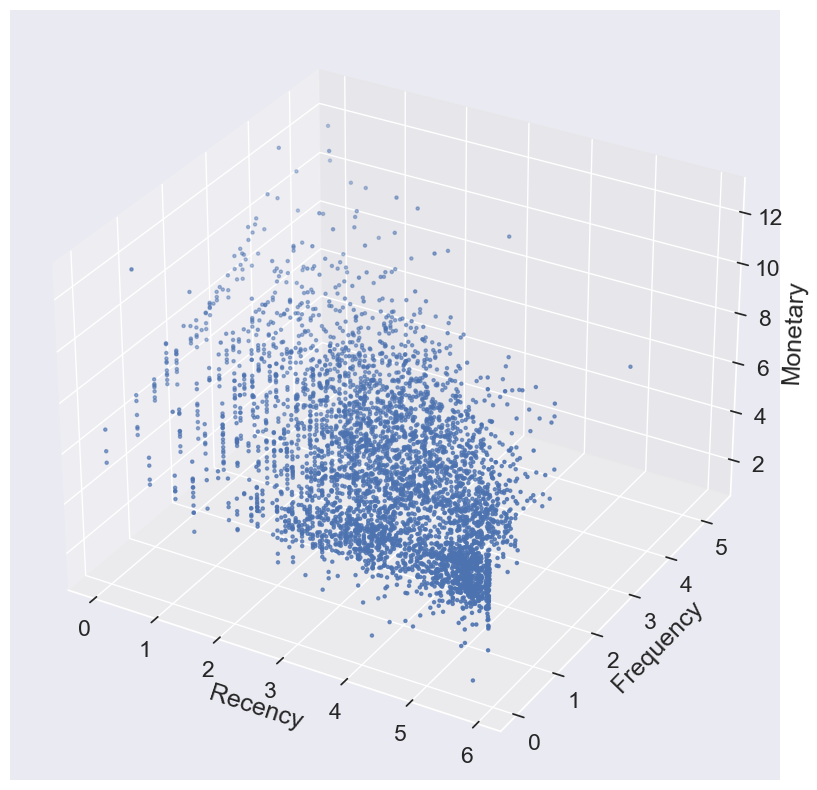

In [112]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

The obvious patterns we can see from the plots above is that costumers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively.

# 1. K-means++
Place the initial centroids far away from each other via the k-means++ algorithm, which leads to better and more consistent results than the classic k-means.
To use k-means++ with scikit-learn's KMeans object, we just need to set the init parameter to k-means++ (the default setting) instead of random.


### 1.1 The Elbow Method
Using the elbow method to find the optimal number of clusters. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly. If k increases, the distortion will decrease, because the samples will be closer to the centroids they are assigned to.
This method looks at the percentage of variance explained as a function of the number of clusters. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified.Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

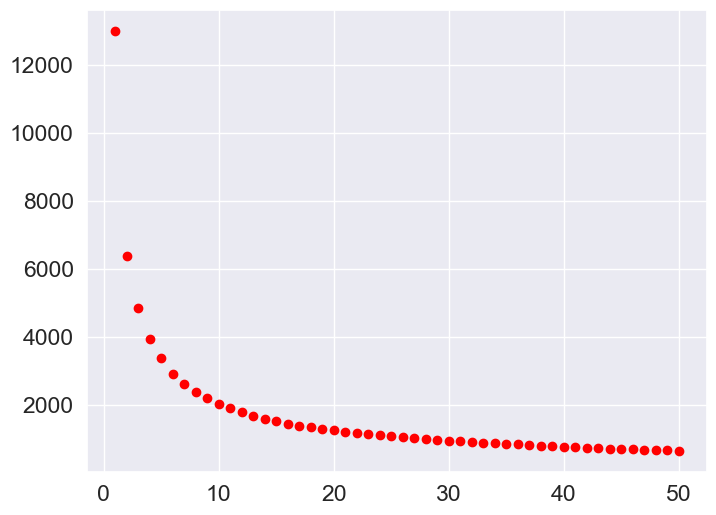

The best K suggest:  7


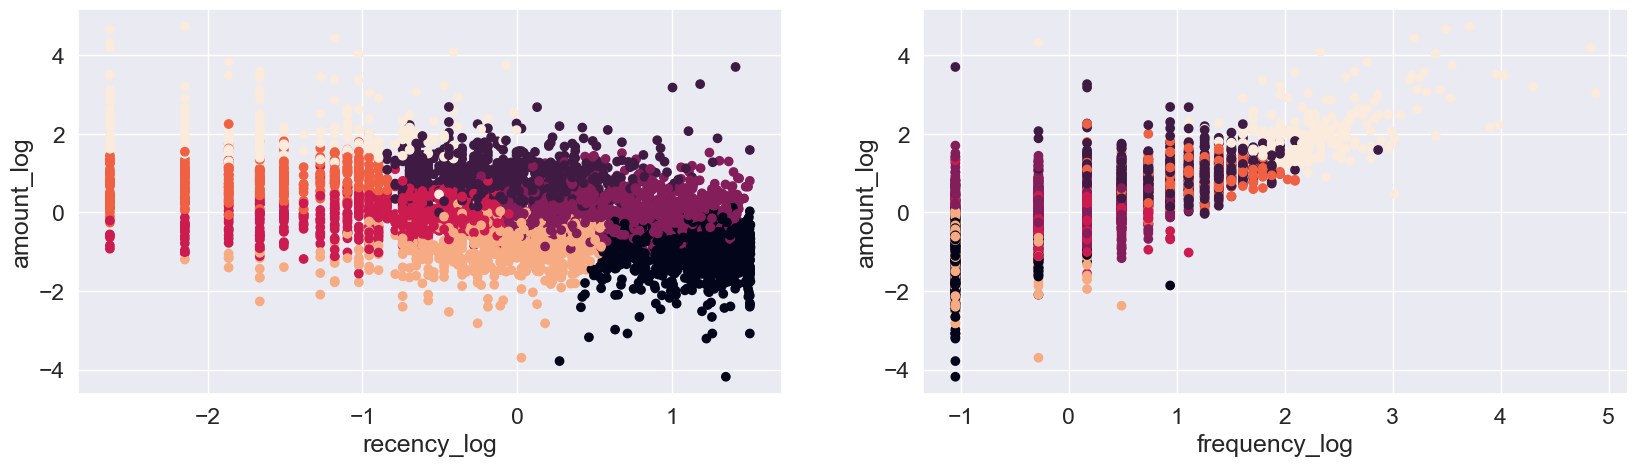

In [118]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K suggest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

From the Elbow method from a K equal to 3 we observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10% with the K equal to 7. With this in mind, we will begin to evaluate the options more deeply with 3, and 7, starting with the silhouette analysis.

## 1.2 Silhouette analysis on K-Means clustering
Silhouette analysis can be used to study the separation of distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. 
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.
It can also be applied to clustering algorithms other than k-means
#### Silhouette coefficients has a range of [-1, 1], it is calculated in the following steps:
##### Calculate the cluster cohesion a( i )as the average distance between a sample x( i ) and all other points in the same cluster.
##### Calculate the cluster separation b( i ) from the next closest cluster as the average distance between the sample x( i ) and all samples in the nearest cluster.
##### Calculate the silhouette s( i ) as the difference between cluster cohesion and separation divided by the greater of the two, as shown here: image Which can be also written as: image Where: If near +1, it indicate that the sample is far away from the neighboring clusters.
##### A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
##### If most objects have a higher value, then the clustering configuration is appropriate.
##### If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
##### A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
##### Negative values indicate that those samples might have been assigned to the wrong cluster.

The silhouette plot can shows a bad K clusters pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. A good k clusters can be found when all the plots are more or less of similar thickness and hence are of similar sizes.

Although we have to keep in mind that in several cases and scenarios, sometimes we may have to drop the mathematical explanation given by the algorithm and look at the business relevance of the results obtained.
Let's see below how our data perform for each K clusters groups (3, 5 and 7) in the silhouette score of each cluster, along with the center of each of the cluster discovered in the scatter plots, by amount_log vs recency_log and vs frequency_log.

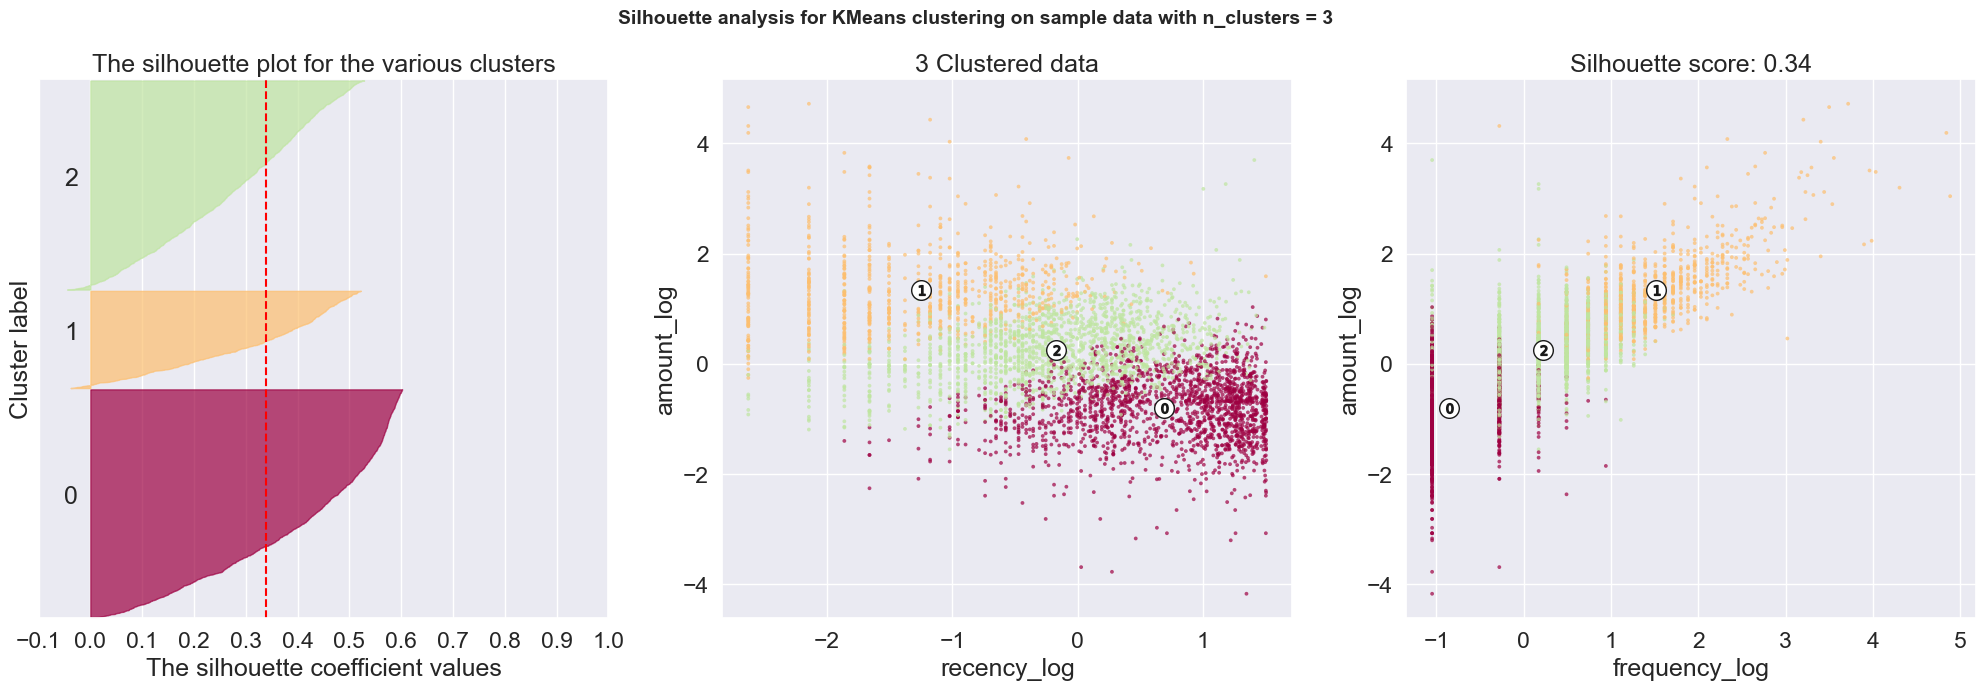

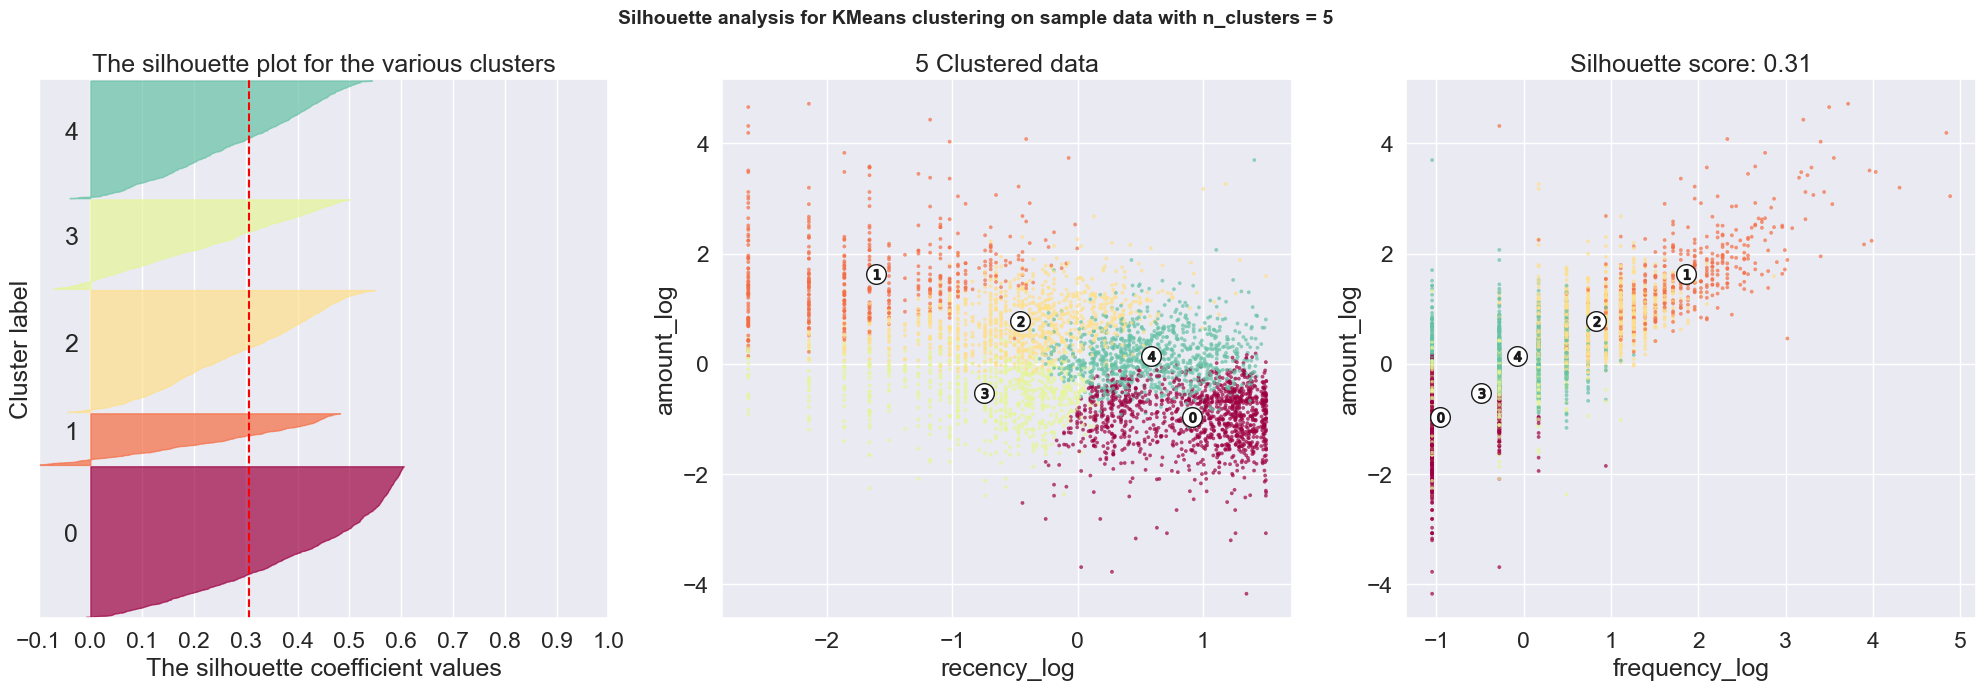

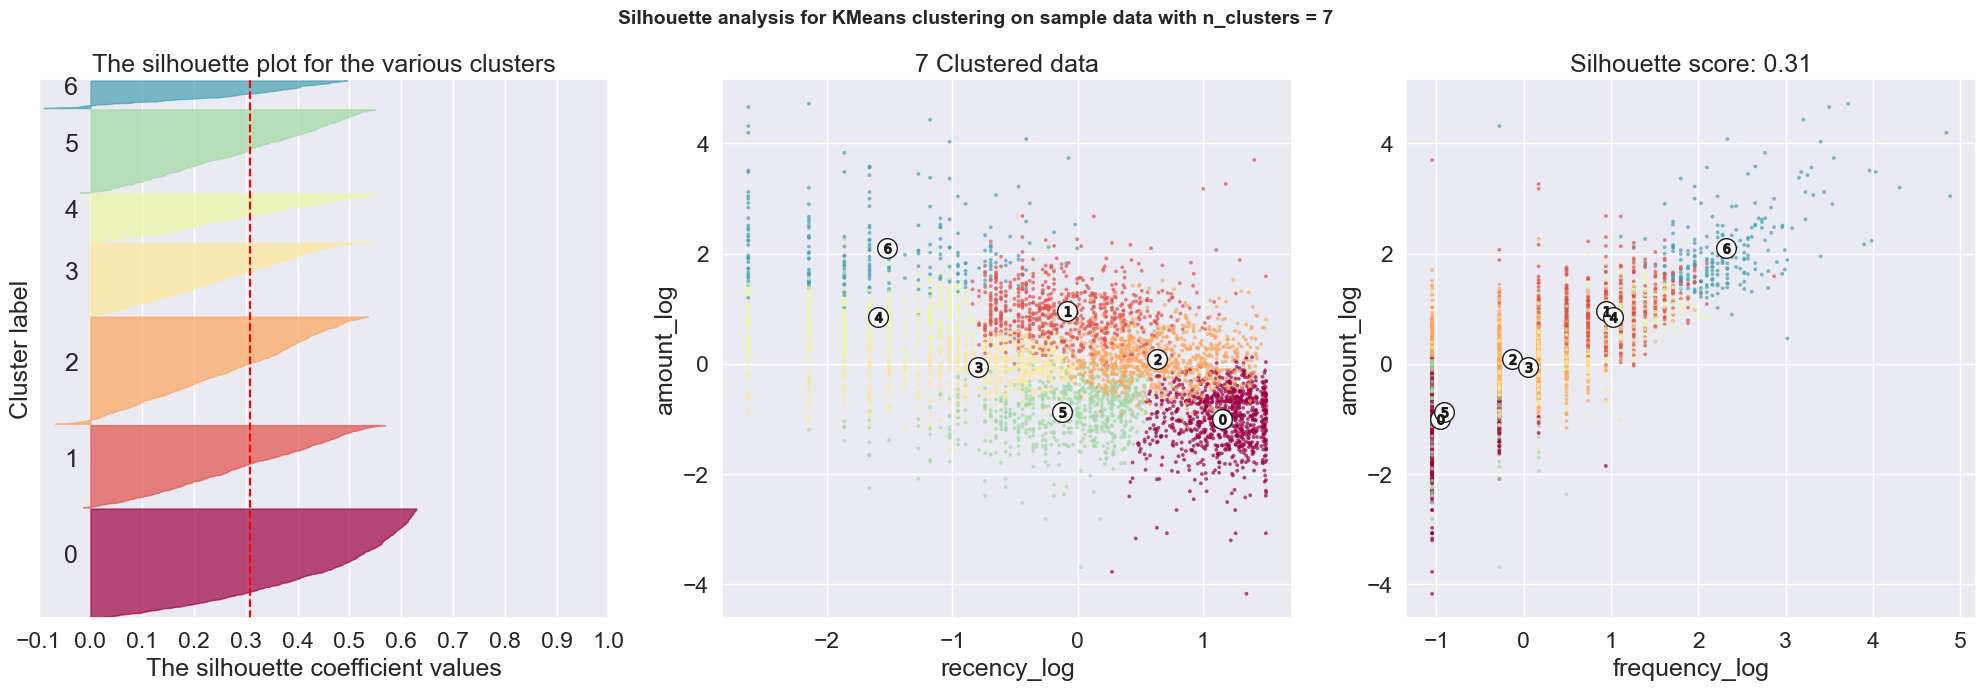

In [119]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

When we look at the results of the clustering process, we can infer some interesting insights:
First notice that all K clusters options is valid, because they don't have presence of clusters with below average silhouette scores.
In the other hand, all options had a some wide fluctuations in the size of the silhouette plots.
So, the best choice may lie on the option that gives us a simpler business explanation and at the same time target customers in focus groups with sizes closer to the desired.

Clusters Center:
Let's look at the cluster center values after returning them to normal values from the log and scaled version.

In [120]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0   261.952265  116.604917   1.190876
1  3967.994380    7.236580  10.044493
2  1006.914317   33.819966   3.152227
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
        amount     recency  frequency
0   213.438964  160.737849   1.088263
1  5708.668108    4.285608  13.677542
2  1930.204520   22.348243   5.414660
3   369.930740   14.854813   1.649874
4   863.647685   99.752358   2.401419
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    205.257565  225.386840   1.083954
1   2447.431580   38.058360   6.037971
2    810.639899  107.621358   2.278104
3    678.481625   13.838593   2.689984
4   2123.643873    4.419742   6.441601
5    240.091620   36.207714   1.134226
6  10213.306074    4.904358  20.795906

#### Clusters Insights:

With the plots and the center in the correct units, let's see some insights by each clusters groups:

***In the three-cluster:***
- The tree clusters appears to have a good differences in the Monetary value of the customer, we will confirm this by a box plot.
- Cluster 1 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
- In the similar way we obtain customer groups with low and medium spends in clusters with labels 0 and 2, respectively.
- Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

***In the five-cluster:***
- Note that clusters 0 and 1 are very similar to their cluster in the configuration with only 3 clusters.
- The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
- The cluster 2 are those who have a decent spend but are not as frequent as the cluster 1
- The cluster 4 purchases medium amounts, with a relatively low frequency and not very recent
- The cluster 3 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket. 
- The silhouette score matrix says that the  five cluster segments are less optimal then the three cluster segments. 

***In the Seven-cluster:***
- Definitely cluster 6 defines those who shop often and with high amount.
- Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.
- Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
- Cluster 5 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.



#### Drill Down Clusters:

To further drill down on this point and find out the quality of these difference, we can label our data with the corresponding cluster label and then visualize these differences. The following code will extract the clustering label and attach it with our customer summary dataset.

CustomerID  recency  frequency    amount  recency_log  frequency_log  \
0       12346    326.0          1  77183.60     5.786897       0.000000   
1       12347      2.0          7   4310.00     0.693147       1.945910   
2       12348     75.0          4   1797.24     4.317488       1.386294   
3       12349     19.0          1   1757.55     2.944439       0.000000   
4       12350    310.0          1    334.40     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.253942           2           4           1  
1    8.368693           1           1           4  
2    7.494007           2           4           1  
3    7.471676           2           3           3  
4    5.812338           0           0           0

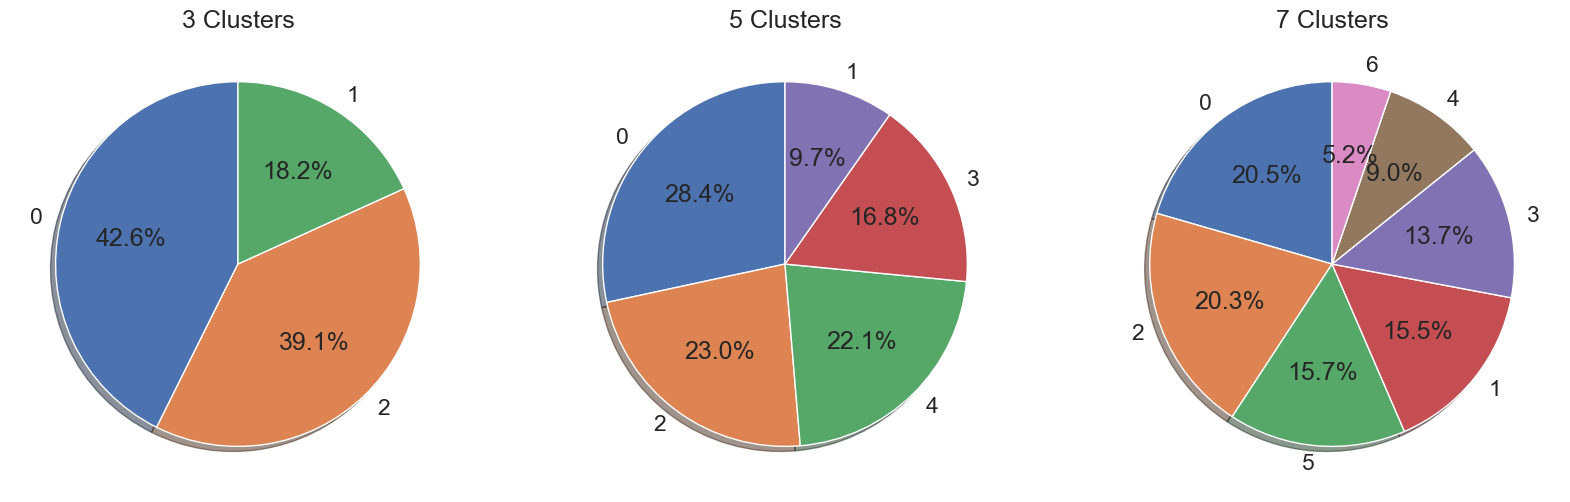

In [121]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

Once we have the labels assigned to each of the customers, our task is simple. Now we want to find out how the summary of customer in each group is varying. If we can visualize that information we will able to find out the differences in the clusters of customers and we can modify our strategy on the basis of those differences.

The following code leverages plotly and will take the cluster labels we got for each configurations clusters and create boxplots. Plotly enables us to interact with the plots to see the central tendency values in each boxplot in the notebook. Note that we want to avoid the extremely high outlier values of each group, as they will interfere in making a good observation around the central tendencies of each cluster. Since we have only positive values, we will restrict the data such that only data points which are less than 0.95th percentile of the cluster is used. This will give us good information about the majority of the users in that cluster segment.



In [122]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

### Next Steps in the Segmentation:
To enhance discovery and can further improve the quality of clustering by adding relevant features, other customer information and purchases details may be included in this dataset.


## Market Basket Analysis with Association Rule-Mining

## Transaction Sales Dataset
##### Let's build a Transaction Sales Table where each product sold will be represented by a column, having its value 1 for when it was sold in that event or zero when not. This will generate a sparse table 

In [135]:
cs_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  amount Internal  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom   15.30      Yes   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom   20.34      Yes   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom   22.00      Yes   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom   20.34      Yes   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom   20.34      Yes   

   days_since_last_purchase  
0                     374.0  
1                     374.0  
2                     374.0  
3                     374.0  
4                     374.0

In [136]:
items = list(cs_df.Description.unique())


In [137]:
grouped = cs_df.groupby('InvoiceNo')

In [128]:
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_level

InvoiceNo                                        Description
0         536365  (WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
1         536366  (HAND WARMER UNION JACK, HAND WARMER RED RETRO...
2         536367  (ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
3         536368  (JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
4         536369                        (BATH BUILDING BLOCK WORD,)
...          ...                                                ...
18527     581583  (LUNCH BAG RED RETROSPOT, 6 CHOCOLATE LOVE HEA...
18528     581584  (RED FLOCK LOVE HEART PHOTO FRAME, 6 CHOCOLATE...
18529     581585  (BLACK TEA TOWEL CLASSIC DESIGN, ASSORTED BOTT...
18530     581586  (LARGE CAKE STAND  HANGING STRAWBERY, SET OF 3...
18531     581587  (CIRCUS PARADE LUNCH BOX , PLASTERS IN TIN CIR...

[18532 rows x 2 columns]

In [132]:
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()

for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)
transaction_df

WHITE HANGING HEART T-LIGHT HOLDER  WHITE METAL LANTERN  \
0                                       1                    1   
1                                       0                    0   
2                                       0                    0   
3                                       0                    0   
4                                       0                    0   
...                                   ...                  ...   
18527                                   0                    0   
18528                                   0                    0   
18529                                   0                    0   
18530                                   0                    0   
18531                                   0                    0   

       CREAM CUPID HEARTS COAT HANGER  KNITTED UNION FLAG HOT WATER BOTTLE  \
0                                   1                                    1   
1                                   0                                    0   
2                                   0                                    0   
3                                   0                                    0   
4                                   0                                    0   
...                               ...                                  ...   
18527                               0                                    0   
18528                               0                                    0   
18529                               0                                    0   
18530                               0                                    0   
18531                               0                                    0   

       RED WOOLLY HOTTIE WHITE HEART.  SET 7 BABUSHKA NESTING BOXES  \
0                                   1                             1   
1                                   0                             0   
2                                   0                             0   
3                                   0                             0   
4                                   0                             0   
...                               ...                           ...   
18527                               0                             0   
18528                               0                             0   
18529                               0                             0   
18530                               0                             0   
18531                               0                             0   

       GLASS STAR FROSTED T-LIGHT HOLDER  HAND WARMER UNION JACK  \
0                                      1                       0   
1                                      0                       1   
2                                      0                       0   
3                                      0                       0   
4                                      0                       0   
...                                  ...                     ...   
18527                                  0                       0   
18528                                  0                       0   
18529                                  0                       0   
18530                                  0                       0   
18531                                  0                       0   

       HAND WARMER RED RETROSPOT  ASSORTED COLOUR BIRD ORNAMENT  ...  \
0                              0                              0  ...   
1                              1                              0  ...   
2                              0                              1  ...   
3                              0                              0  ...   
4                              0                              0  ...   
...                          ...                            ...  ...   
18527                          0                              0  ...   
18528                          

### Prune Dataset for frequently purchased items

Our EDA analysis shows how only a handful of items are responsible for bulk of our sales,  so we want to prune our dataset to reflect this information. For this we will create a function prune_dataset which will help us reduce the size of our dataset based on our requirements. This function can be used for performing three types of pruning:

- Pruning based on percentage of total sales: The parameter total_sales_perc will help us select the number of items that will explain the required percentage of sales. The default value is 50% or 0.5.
- Pruning based on ranks of items: Another way to perform the pruning is to specify the starting and the ending rank of the items for which we want to prune our dataset.
- Pruning based on list of features passed to the parameter TopCols. 

By default, we will only look for transactions which have at least two items, as transactions with only one item are counter to the whole concept of association rule-mining. 

In [139]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

#### Pruning based on Ranks -- Top 15 products in Sales

In [140]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 778377.21
Number of Sales Events: 4664
Number of Products: 15


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        1978
1             REGENCY CAKESTAND 3 TIER        1703
2              JUMBO BAG RED RETROSPOT        1600
3                        PARTY BUNTING        1379
4        ASSORTED COLOUR BIRD ORNAMENT        1375
5              LUNCH BAG RED RETROSPOT        1289
6    SET OF 3 CAKE TINS PANTRY DESIGN         1146
7                              POSTAGE        1099
8             JUMBO BAG VINTAGE DOILY         1080
9              LUNCH BAG  BLACK SKULL.        1052
10              LUNCH BAG SUKI DESIGN         1043
11                      POPCORN HOLDER        1035
12     PACK OF 72 RETROSPOT CAKE CASES        1029
13                      SPOTTY BUNTING        1009
14            LUNCH BAG VINTAGE DOILY         1006

#### Association Rule Mining with FP Growth

##### Orange Table Data Structure
Since we are using the Orage framework we still have to convert it to the Table data structure by providing the metadata about our columns. We need to define the domain for each of our variables. The domain means the possible set of values that each of our variables can use. This information will be stored as metadata and will be used in later transformation of the data. As our columns are only having binary values,we can easily create the domain by using this information. 

In [143]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.values,Y= None)

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

##### Creating our rules
We need to specify two pieces of information for generating our rules: support and confidence. An important piece of information is to start with a higher support, as lower support will mean a higher number of frequent itemsets and hence a longer execution time. We will specify a min support of 0.01 and see the number of frequent itemsets that we get before we specify confidence and generate our rules.

In [144]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  46
Items Set Size: 663273


So we get a whopping 663.273 itemsets for only 15 itens and a support of only 1%! This will increase exponentially if we decrease the support or if we increase the number of items in our dataset. The next step is specifying a confidence value and generating our rules. The following code snippet will perform rule generation and decoding of rules, and then compile it all in a neat dataframe that we can use for further analysis.

In [145]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 25247 rules generated


#### Explore The Association Rule Created
##### Let's see what we get in the first 5 rules with highest confidence:

In [146]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
20   JUMBO BAG VINTAGE DOILY    
133  LUNCH BAG VINTAGE DOILY    
134  LUNCH BAG VINTAGE DOILY    
131  LUNCH BAG VINTAGE DOILY    
21   JUMBO BAG VINTAGE DOILY    

                                                                                             antecedent  \
20                           JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, LUNCH BAG VINTAGE DOILY    
133  LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN    
134                           LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN    
131                          LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL.   
21                            JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN , LUNCH BAG VINTAGE DOILY    

     support  confidence      lift  
20        60    0.909091  4.520256  
133       49    0.890909  4.596460  
134       48    0.888889  4.586037  
131       48    0.872727  4.502655  
21        48    0.872727  4.339446

##### Let's see what we get in the first 5 with highest support

In [148]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent  \
123  LUNCH BAG VINTAGE DOILY    
28   JUMBO BAG VINTAGE DOILY    
92    LUNCH BAG RED RETROSPOT   
77    LUNCH BAG RED RETROSPOT   
4     JUMBO BAG RED RETROSPOT   

                                            antecedent  support  confidence  \
123  JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      154    0.777778   
28   LUNCH BAG VINTAGE DOILY , JUMBO BAG RED RETROSPOT      153    0.805263   
92    LUNCH BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN       149    0.668161   
77     LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN       142    0.601695   
4    JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      138    0.696970   

         lift  
123  4.012783  
28   4.003995  
92   2.672646  
77   2.406780  
4    2.688723

Typically, a lift value of 1 indicates that the probability of occurrence of the antecedent and consequent together are independent of each other. Hence, the idea is to look for rules having a lift much greater than 1. So, let's see how much rules has lift greater than 1, equal 1 and less than one:

In [147]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

Greater Than One    25247
Name: lift, dtype: int64

In [149]:
pd.options.display.max_colwidth = dw

### Conclusion
The rules with low support and high confidence would be our target for further study and then outlining the strategies to raise cross selling.